In [60]:
import bs4
import requests
import pandas as pd


# nie mozemy uzyc pandas.read_html bo strona nie zawiera tagu <table> tylko <div>
BASE_URL = 'https://www.lista.e-sieci.pl/58,page,{},Zabka.html#placesTable'
NUMBER_OF_PAGES_ON_WEBSITE = 94

all_rows = []

for i in range(NUMBER_OF_PAGES_ON_WEBSITE):
    response = requests.get(BASE_URL.format(i))

    soup = bs4.BeautifulSoup(response.content, 'html.parser')
    towns = soup.find_all('div', class_='name')
    # remove the header
    towns = towns[1:]
    regions = soup.find_all('div', class_='region')
    # remove the header
    regions = regions[1:]

    rows_on_current_page = []

    for i in range(len(towns)):
        # we remove the text "Zabka" and leave just the town name
        new_row = [towns[i].text.split('  ', 1)[1], regions[i].text]
        rows_on_current_page.append(new_row)

    all_rows = all_rows + rows_on_current_page

df = pd.DataFrame(all_rows, columns= ['place', 'region'])

# save all data to csv file

df.to_csv('zabkas.csv')


In [40]:
import bs4
import requests
import pandas as pd
# imports are repeated because the first cell takes a lot to run, and I don't want to run
# it multiple times in testing

fields=['place', 'region']

frame = pd.read_csv('zabkas.csv', usecols=fields)

frame

,place,region
0,Andrespol,łódzkie
1,Łódź,łódzkie
2,Łódź,łódzkie
3,Łódź,łódzkie
4,Łódź,łódzkie
...,...,...
2345,Kępno,wielkopolskie
2346,Kępno,wielkopolskie
2347,Kępno,wielkopolskie
2348,Odolanów,wielkopolskie


Strona z listą żabek nie posiada wszystkich istniejących rzeczywiście sklepów

In [41]:
fields = [1, 5, 7]
col_names = ['place', 'total_pop', 'density']
pop_data = pd.read_csv('town_data.csv', usecols=fields, header=3, names=col_names)


pop_data

,place,total_pop,density
0,WOJ. DOLNOŚLĄSKIE,NaN,NaN
1,Powiat bolesławiecki (6 gmin),NaN,NaN
2,gmina miejska urban gmina,NaN,NaN
3,Bolesławiec....................................,38935.0,1652.0
4,gminy wiejskie rural gminas,NaN,NaN
...,...,...,...
4867,obszar wiejski rural area.................,3038.0,13.0
4868,Miasta na prawach powiatu (3) Cities with po...,NaN,NaN
4869,Koszalin.......................................,107321.0,1091.0
4870,Szczecin (b)...................................,402465.0,1339.0


In [42]:
# removing rows with no numerical values for population and density
# most of them is sub-headers for voievodeships or types of regions
pop_data = pop_data.dropna()

# removing rows containing 'miasto' or 'obszar wiejski' which are 
# values split, we don't need them because the sum of city and rural region
# is already in the row with the city name
pop_data = pop_data[~pop_data.place.str.contains('obszar wiejski') & ~pop_data.place.str.contains('miasto')]

# removing unnecessary dots from place names
# as well as (a) (b) (c) which denote airport, port or border crossing in the original excel file
pop_data['place'] = pop_data['place'].map(lambda x: x.rstrip('. ').lstrip(' M.st.').replace(' (a)', '').replace(' (b)', '').replace(' (c)', ''))

pop_data

,place,total_pop,density
3,Bolesławiec,38935.0,1652.0
5,Bolesławiec,14626.0,51.0
6,Gromadka,5367.0,20.0
7,Osiecznica,7371.0,17.0
8,Warta Bolesławiecka,8643.0,78.0
...,...,...,...
4862,irosławiec,5474.0,27.0
4865,Tuczno,4954.0,20.0
4869,Koszalin,107321.0,1091.0
4870,Szczecin,402465.0,1339.0


In [43]:
# check if there are duplicates
pop_data[pop_data['place'].duplicated(keep=False)]

# it turns out that there is a duplicate for each 'gmina' if
# there is both an urban and rural community with the same name

,place,total_pop,density
3,Bolesławiec,38935.0,1652.0
5,Bolesławiec,14626.0,51.0
16,Dzierżoniów,33344.0,1661.0
19,Dzierżoniów,9138.0,65.0
30,Głogów,67615.0,1926.0
...,...,...,...
4830,Szczecinek,9278.0,19.0
4843,Świdwin,15594.0,697.0
4848,Świdwin,5907.0,24.0
4855,Wałcz,25359.0,664.0


In [44]:
# deleting the duplicates found previously, with keeping the first one and removing others
# in the file urban community is always first, this way we keep the urban communities and 
# remove the surrounding rural communities, which we do not need
pop_data = pop_data.drop_duplicates(subset='place', keep='first')   # explicitly specify first for readability
pop_data

,place,total_pop,density
3,Bolesławiec,38935.0,1652.0
6,Gromadka,5367.0,20.0
7,Osiecznica,7371.0,17.0
8,Warta Bolesławiecka,8643.0,78.0
10,Nowogrodziec,15258.0,87.0
...,...,...,...
4862,irosławiec,5474.0,27.0
4865,Tuczno,4954.0,20.0
4869,Koszalin,107321.0,1091.0
4870,Szczecin,402465.0,1339.0


In [45]:
# merging the dataframe with Żabka shops and dataframe with population data
merged_df = pd.merge(frame, pop_data, how='left')
merged_df

,place,region,total_pop,density
0,Andrespol,łódzkie,14083.0,547.0
1,Łódź,łódzkie,685285.0,2337.0
2,Łódź,łódzkie,685285.0,2337.0
3,Łódź,łódzkie,685285.0,2337.0
4,Łódź,łódzkie,685285.0,2337.0
...,...,...,...,...
2345,Kępno,wielkopolskie,24546.0,198.0
2346,Kępno,wielkopolskie,24546.0,198.0
2347,Kępno,wielkopolskie,24546.0,198.0
2348,Odolanów,wielkopolskie,14628.0,107.0


In [46]:
# replacing many rows with shops from the same city with one row with the number of shops in this city

counted = merged_df.groupby(merged_df.columns.to_list()).size().reset_index().rename(columns={0:'shops'})

In [47]:
# scraping gdp per capita of voievodeships

GDP_URL = 'http://eregion.wzp.pl/wskaznik/produkt-krajowy-brutto-na-1-mieszkanca'
response = requests.get(GDP_URL)
soup = bs4.BeautifulSoup(response.content, 'html.parser')

# check what are the class names of the tables
classes = [table.get('class') for table in soup.find_all('table')]
print(classes)

# the website has 7 tables of the same class, so we use index to pick the correct one
table = soup.find_all('table')[0]

all_rows = []

for row in table.tbody.find_all('tr'):
    columns = row.find_all('td')
    region = columns[1].text.lower()
    latest_gdp = int(columns[-1].text.replace(' ', ''))

    if region != 'polska':
        all_rows.append([region, latest_gdp])


gdp_frame = pd.DataFrame(all_rows, columns = ['region', 'gdp_per_capita'])


[['dataTable'], ['dataTable'], ['dataTable'], ['dataTable'], ['dataTable'], ['dataTable'], ['dataTable']]


In [48]:
# merging the main dataframe with gdp per capita dataframe

counted = pd.merge(counted, gdp_frame, how='left')
counted

,place,region,total_pop,density,shops,gdp_per_capita
0,Andrespol,łódzkie,14083.0,547.0,2,43736
1,Andrychów,małopolskie,43654.0,435.0,1,42139
2,Augustów,podlaskie,30242.0,374.0,1,33230
3,Barlinek,zachodniopomorskie,19377.0,75.0,2,39693
4,Bełchatów,łódzkie,57432.0,1658.0,9,43736
...,...,...,...,...,...,...
385,Żary,lubuskie,37682.0,1125.0,8,39042
386,Żarów,dolnośląskie,12443.0,142.0,1,52128
387,Żory,śląskie,62456.0,966.0,13,48702
388,Żyrardów,mazowieckie,39992.0,2787.0,3,74550


In [50]:
# scraping urbanization index of voievodeships

GDP_URL = 'http://eregion.wzp.pl/wskaznik/wskaznik-urbanizacji'
response = requests.get(GDP_URL)
soup = bs4.BeautifulSoup(response.content, 'html.parser')

# we find the table on the website
table = soup.find_all('table')[0]

all_rows = []

for row in table.tbody.find_all('tr'):
    columns = row.find_all('td')
    region = columns[0].text.lower()
    urbanization_index = float(columns[-1].text.replace(',', '.'))

    if region != 'polska':
        all_rows.append([region, urbanization_index])


urbanization_frame = pd.DataFrame(all_rows, columns = ['region', 'urbanization_index'])
urbanization_frame

,region,urbanization_index
0,śląskie,76.45
1,zachodniopomorskie,68.26
2,dolnośląskie,68.18
3,lubuskie,64.73
4,mazowieckie,64.43
5,pomorskie,63.19
6,łódzkie,62.28
7,podlaskie,60.84
8,warmińsko-mazurskie,59.05
9,kujawsko-pomorskie,58.56


In [51]:
# merging the main dataframe with urbanization index dataframe

counted = pd.merge(counted, urbanization_frame, how='left')
counted

,place,region,total_pop,density,shops,gdp_per_capita,urbanization_index
0,Andrespol,łódzkie,14083.0,547.0,2,43736,62.28
1,Andrychów,małopolskie,43654.0,435.0,1,42139,48.08
2,Augustów,podlaskie,30242.0,374.0,1,33230,60.84
3,Barlinek,zachodniopomorskie,19377.0,75.0,2,39693,68.26
4,Bełchatów,łódzkie,57432.0,1658.0,9,43736,62.28
...,...,...,...,...,...,...,...
385,Żary,lubuskie,37682.0,1125.0,8,39042,64.73
386,Żarów,dolnośląskie,12443.0,142.0,1,52128,68.18
387,Żory,śląskie,62456.0,966.0,13,48702,76.45
388,Żyrardów,mazowieckie,39992.0,2787.0,3,74550,64.43


,total_pop,density,shops,gdp_per_capita,urbanization_index
total_pop,1.000000,0.421798,0.863079,0.108830,0.020683
density,0.421798,1.000000,0.409514,0.133289,0.102781
shops,0.863079,0.409514,1.000000,0.057528,0.062500
gdp_per_capita,0.108830,0.133289,0.057528,1.000000,0.370953
urbanization_index,0.020683,0.102781,0.062500,0.370953,1.000000


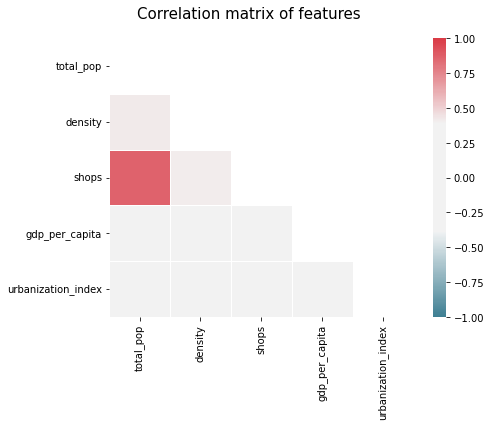

In [52]:
# correlation

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

corr = counted.corr()
# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
fig, ax = plt.subplots(figsize=(7, 6))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True, sep=100)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmin=-1, vmax=1, center=0, linewidths=.5)


fig.suptitle('Correlation matrix of features', fontsize=15)


fig.tight_layout()
corr

Widzimy korelację liczby ludności i liczby sklepów, co jest oczywiste, dlatego zajmiemy się liczbą sklepów na mieszkańca i podzielimy te dwie wartości.

In [53]:
final_df = counted.copy()
final_df['shops_per_person'] = final_df.shops / final_df.total_pop
final_df.dtypes

place                  object
region                 object
total_pop             float64
density               float64
shops                   int64
gdp_per_capita          int64
urbanization_index    float64
shops_per_person      float64
dtype: object

In [102]:
from sklearn import linear_model

features = ['gdp_per_capita', 'urbanization_index']
target = ['total_pop']

X = final_df[features].values.reshape(-1, len(features))
y = final_df[target].values

ols = linear_model.LinearRegression()
model = ols.fit(X, y)

In [103]:
model.coef_

array([[   1.42848746, -276.55887584]])

In [104]:
model.intercept_

array([-4.83878739])

In [105]:
model.score(X, y)

0.012293479572551225